In [ ]:
"""
NAME: Keenan Samway
DATE: May, 2021
CLASS: GBUS 401 Big Data in Business, Economy, Society
ASSIGNMENT: Final Project
"""

In [1]:
%%capture
pip install geopandas

In [2]:
# Import relevant libraries
import pandas as pd
import numpy as np
import collections
import random
import json, os
import urllib.request
import requests
import glob
import shutil

import matplotlib.pyplot as plt

import descartes
import geopandas as gpd
import pickle

from shapely.geometry import Point, Polygon

from tensorflow.keras.preprocessing import image

In [3]:
# Google API Key
key = ''

# Google API Authenticating Secret
secret = ''

# Directories for storing images
dataDir = '/content/drive/My Drive/- 2021 Spring/GBUS 401/AIguessr/Images/Images_Split'
dataCombinedDir = '/content/drive/My Drive/- 2021 Spring/GBUS 401/AIguessr/Images/Images_Combined'

In [4]:
# Change to working directory that contains 'weco.csv'

%cd '/content/drive/My Drive/- 2021 Spring/GBUS 401/AIguessr/'
!ls

/content/drive/My Drive/- 2021 Spring/GBUS 401/AIguessr
 AIguessr.gdoc
 AIguessr.ipynb
 AIguessr_Trained_Model_1_Dense_33.h5
 AIguessr_Trained_Model_1_Res_45.h5
 AIguessr_Trained_Model_2_Dense_38.h5
 AIguessr_Trained_Model_2_Res_30.h5
 AIguessr_Trained_Model_2_Res_38.h5
 AIguessr_Trained_Model_2_Res_47.h5
 AIguessr_Trained_Model_2_Res_49.h5
 AIguessr_Trained_Model_4-1_Res_35.h5
 AIguessr_Trained_Model_4-1_Res_43.h5
 AIguessr_Trained_Model_4-1_Res_47.h5
 AIguessr_Trained_Model_4-2_Res_48.h5
 AIguessr_Trained_Model_4-2_Res_52.h5
 AIguessr_Trained_Model_4-3_Res_53.h5
 AIguessr_Trained_Model_4-4_Dense_.h5
 AIguessr_Trained_Model_4-4_Res_54.h5
 AIguessr_Trained_Model_4_Res_27.h5
 ca_county19
 cb_2019_us_county_500k
 co_county19
'Copy of AIguessr_Trained_Model_4-3_Res_52.h5'
 createModel.ipynb
'Design Document.gdoc'
 generateMap.ipynb
 getImages.ipynb
 Images
 us_county19


In [5]:
IN_FILE = '/content/drive/My Drive/- 2021 Spring/GBUS 401/AIguessr/co_county19/co_county19.shp'

co_map_detailed = gpd.read_file( IN_FILE )

co_map = co_map_detailed.drop( columns=['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'LSAD', 'ALAND', 'AWATER'] )\

co_map.head()

,GEOID,NAME,geometry
0,08077,Mesa,"POLYGON ((-109.06025 38.59933, -109.05954 38.7..."
1,08107,Routt,"POLYGON ((-107.44259 40.33476, -107.43207 40.3..."
2,08055,Huerfano,"POLYGON ((-105.50129 37.59860, -105.49327 37.6..."
3,08001,Adams,"POLYGON ((-105.05329 39.85676, -105.05323 39.8..."
4,08059,Jefferson,"MULTIPOLYGON (((-105.05584 39.62599, -105.0533..."


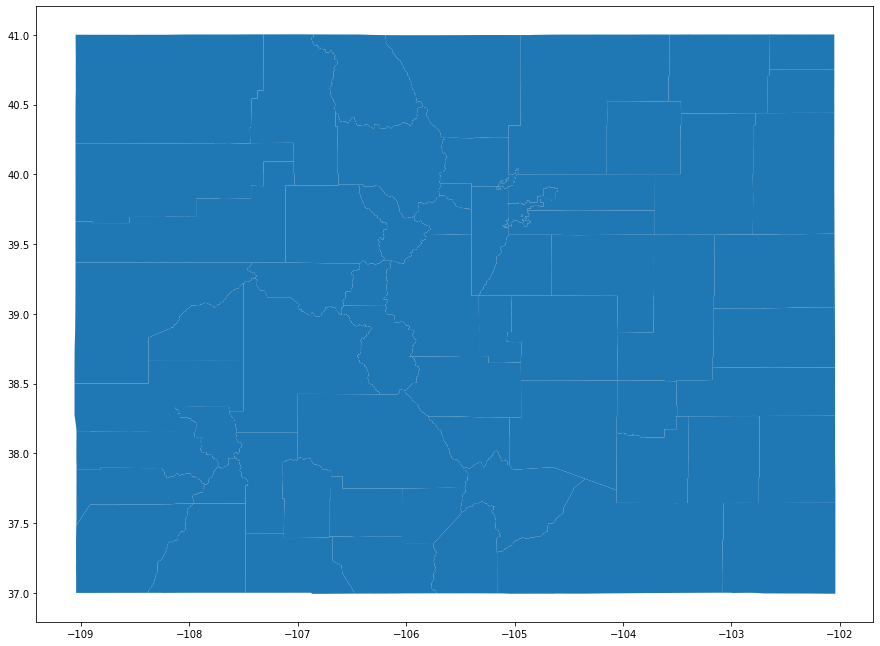

In [6]:
fig, ax = plt.subplots(figsize=(15,15))
co_map.plot( ax=ax )

In [7]:
# Generate num random points inside a polygon
def generate_random_points( num, polygon ):
    points = []
    minx, miny, maxx, maxy = polygon.bounds

    while len( points ) < num:
        p = Point( random.uniform( minx, maxx ), random.uniform( miny, maxy ) )
        if polygon.contains( p ):
            points.append( p )

    return points

# Generate a random point inside a polygon
def generate_random( polygon ):
    point = []
    minx, miny, maxx, maxy = polygon.bounds

    while len( point ) < 1:
        p = Point( random.uniform( minx, maxx ), random.uniform( miny, maxy ) )
        if polygon.contains( p ):
            point.append( p )

    return point[0]

# Return true if two lists are equal, regardless of order
def check_equal( a, b ):
    if len( a ) != len( b ):
        return False
    return collections.Counter( a ) == collections.Counter( b )

In [ ]:
# https://developers.google.com/maps/documentation/streetview/get-api-key

""" Signs a URL using a URL signing secret """

import hashlib
import hmac
import base64
import urllib.parse as urlparse


def sign_url(input_url=None, secret=None):
    """ Sign a request URL with a URL signing secret.
      Usage:
      from urlsigner import sign_url
      signed_url = sign_url(input_url=my_url, secret=SECRET)
      Args:
      input_url - The URL to sign
      secret    - Your URL signing secret
      Returns:
      The signed request URL
    """

    if not input_url or not secret:
        raise Exception("Both input_url and secret are required")

    url = urlparse.urlparse(input_url)

    # We only need to sign the path+query part of the string
    url_to_sign = url.path + "?" + url.query

    # Decode the private key into its binary format
    # We need to decode the URL-encoded private key
    decoded_key = base64.urlsafe_b64decode(secret)

    # Create a signature using the private key and the URL-encoded
    # string using HMAC SHA1. This signature will be binary.
    signature = hmac.new(decoded_key, str.encode(url_to_sign), hashlib.sha1)

    # Encode the binary signature into base64 for use within a URL
    encoded_signature = base64.urlsafe_b64encode(signature.digest())

    original_url = url.scheme + "://" + url.netloc + url.path + "?" + url.query

    # Return signed URL
    return original_url + "&signature=" + encoded_signature.decode()

In [ ]:
print( co_map.keys() )

Index(['GEOID', 'NAME', 'geometry'], dtype='object')


In [ ]:
#searchCounties = ['08014'] # check specific counties
searchCounties = co_map['GEOID'].to_list()

print("Searching Grids: {}".format("All" if check_equal( searchCounties, co_map['GEOID'].to_list() ) else searchCounties ))

Searching Grids: All


In [ ]:
# https://developers.google.com/maps/documentation/streetview/overview#url_parameters

base = 'https://maps.googleapis.com/maps/api/streetview'
ext = '?size=600x600&location={}&fov=100&heading={}&radius={}&pitch=0&source=outdoor&key={}'
# Constant Parameters: size=600x600, fov=100, pitch=0, source=outdoor

nPerCounty = 50
nTrials = 20

for geoid, county in zip( co_map['GEOID'].to_list(), co_map['geometry'].to_list() ):

    count = 0
    trials = 0
    locList = []

    if geoid in searchCounties:
        # Create folder for county GEOID in '/data' (if doesn't exist, make new directory)
        saveFolder = dataDir + '/{}'.format( geoid )
        if os.path.exists( saveFolder ) == False:
            os.mkdir( saveFolder )
        
        # Retrieve list of folders in this directory which correspond to previously found locations in this GEOID
        locList = os.listdir( saveFolder )

        print( "---------- Serach County {} ----------".format( geoid ) )
        print( "Save folder {}".format( saveFolder ) )
        print( "Existing locations {}".format( locList ) )

        # Repeat nPerCounty times or until too many attempts/trials done
        while count < nPerCounty and trials < nTrials:
            # Generate random point within county
            pnt = generate_random( county )
            location = str( pnt.y ) + ',' + str( pnt.x )

            # If point is in county and not previously retrieved
            if ( county.contains( pnt ) ) and ( location not in locList ):
                # Request metadata
                metaUrl = base + '/metadata' + ext.format( location, 0, 20000, key)
                metaUrlSigned = sign_url( metaUrl, secret )
                r = requests.get( metaUrlSigned ).json()
                trials += 1
                print( "Trial: {}, count: {}".format( trials, count ) )
                print( "Status: {}".format( r['status'] ) )

                # If location is valid and within county
                if r['status'] == 'OK' and county.contains( Point( r['location']['lng'], r['location']['lat'] ) ):
                    # Update location string to found location
                    location = str( r['location']['lat'] ) + ',' + str( r['location']['lng'] )
                    
                    # If location is not previously retrieved
                    if ( location not in locList ):
                        # Add valid location to locList records
                        print( "Valid location found: {}".format( location ) )
                        locList.append( location )

                        # Create folder for individual location in '/data/<GEOID>/' (if doesn't exist, make new directory)
                        saveFile = saveFolder + "/{}".format( location )
                        if os.path.exists( saveFile ) == False:
                            os.mkdir( saveFile )

                        # Iterate over each heading {N, E, S, W}
                        for heading in [0, 90, 180, 270]:
                            # Retrieve images for each heading
                            imgUrl = base + ext.format( location, heading, 20000, key )
                            imgUrlSigned = sign_url( imgUrl, secret )
                            toSave = saveFile + '/{}_{}.jpg'.format( heading, r['date'] )

                            #print( "RETRIEVE FROM: {}".format( imgUrlSigned ) )
                            #print( "SAVE TO:       {}".format( toSave ) )

                            ''' Uncomment to retrieve image files '''
                            #urllib.request.urlretrieve( imgUrlSigned, saveFile + '/{}_{}.jpg'.format( heading, r['date'] ) )
                        
                        count += 1
                        trials = 0
                    else:
                        # Location has already been retrieved
                        print( "Failed trial {} location exists".format( trials ) )
                        print( "Location {}".format( location ) )
                else:
                    # Image not available or not within county
                    print( "Failed trial {} status or contains".format( trials ) )
                    print( "Location {}".format( location ) )
        
        print( locList )
        print( "No duplicated: {}".format( len( locList ) == len( set( locList ) ) ) )
        print( "---------- Final locations for county {}: {} ----------".format( geoid, len( locList ) ) )
        print()

---------- Serach County 08014 ----------
Save folder /content/drive/My Drive/- 2021 Spring/GBUS 401/AIguessr/Images/Images_Split/08014
Existing locations ['39.91835083969777,-105.0749766206408', '39.94325417768734,-105.0579145803471', '39.92175888485863,-105.1267940532766', '39.91993507736754,-105.0826128453578', '39.99794572026627,-105.0227266388946', '39.91452021889165,-105.1010486914355', '39.9505123,-105.0167078', '39.92615052011246,-105.1298435687689', '39.94307954644297,-105.057915095988', '39.924011,-105.0461624', '39.9712451,-105.0446663', '39.94864971959321,-105.0089929462251', '39.91881757036932,-105.1123246364781', '39.93190874213144,-105.1335752983401', '39.95622356623531,-105.0160616373363', '39.92182922278818,-105.1267369784176']
Trial: 1, count: 0
Status: OK
Valid location found: 39.92092008099573,-105.1101013167118
Trial: 1, count: 1
Status: OK
Failed trial 1 status or contains
Location 39.98317655235753,-104.99906719728719
Trial: 2, count: 1
Status: OK
Failed trial 2 

In [8]:
# Create dictionary of county GEOIDs and their corresponding locations
gdsLoc = {}
for g in os.listdir( dataDir ):
    gdsLoc[g] = []
    for loc in os.listdir( dataDir + "/{}".format( g ) ):
        locLst = list( map( lambda x:float( x ), loc.split( ',' ) ) )

        gdsLoc[g].append( locLst )

In [ ]:
# Check if all zip codes are full
allFilled = True
for grd, locs in gdsLoc.items():
    if len( locs ) < nPerCounty:
        print( "County {}: {} locations".format( grd, len( locs ) ) )
        allFilled = False

print( "All Filled: {}".format( allFilled ) )

All Filled: True


In [9]:
# Gather points for all photos
allLocations = []
for grd, locs in gdsLoc.items():
    for lc in locs:
        loc = ','.join( [str( i ) for i in lc] )
        allLocations.append( Point( float( lc[1] ), float( lc[0] ) ) )

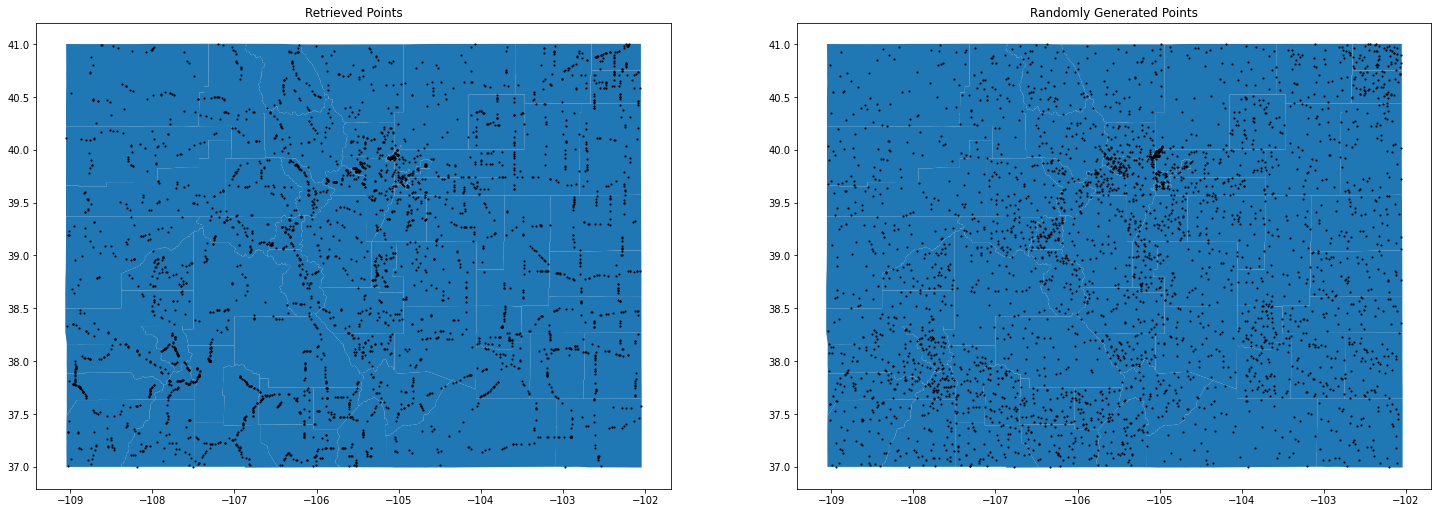

In [10]:
# Map out retrieved points and compare with randomly generated set

# Randomly Distributed
geometry = []
for county in co_map['geometry'].to_list():
    geometry += [generate_random( county ) for n in range( 50 )]

# Create GeoDataSets
crs = 'epsg:4326'
retrieved_gpd = gpd.GeoDataFrame( crs=crs, geometry=allLocations )
random_gpd = gpd.GeoDataFrame( crs=crs, geometry=geometry )

# Plot
fig, ( ax1, ax2 ) = plt.subplots( 1, 2, figsize=( 25, 12 ) )
co_map.plot( ax=ax1 )
retrieved_gpd.plot( ax=ax1, markersize=5, color='black', marker='.' )
ax1.set_title( 'Retrieved Points')

co_map.plot( ax=ax2 )
random_gpd.plot( ax=ax2, markersize=5, color='black', marker='.' )
ax2.set_title( 'Randomly Generated Points')
plt.show()

In [ ]:
# Move files to new folder and rename

coloradoDir = '/content/drive/My Drive/- 2021 Spring/GBUS 401/AIguessr/Images/Colorado/Split'

# For each county/GEOID in the dictionary
for grd, locs in gdsLoc.items():
    # For each location in the county (pop it off)
    for lc in locs:
        loc = ','.join( [str( i ) for i in lc] )
        #print( loc )

        # For each heading in the location
        for img in os.listdir( dataDir + "/{}/{}".format( grd, loc ) ):
            prevDir = dataDir + '/{}/{}'.format( grd, loc )
            saveDir = coloradoDir + "/{}".format( grd )
            if os.path.exists( saveDir ) == False:
                os.mkdir( saveDir )
            os.rename( prevDir + '/{}'.format( img ), saveDir + "/{}+{}+{}".format( grd, loc, img ) )

In [ ]:
geoids = co_map['GEOID'].values

geoids.sort()

print( geoids )

['08001' '08003' '08005' '08007' '08009' '08011' '08013' '08014' '08015'
 '08017' '08019' '08021' '08023' '08025' '08027' '08029' '08031' '08033'
 '08035' '08037' '08039' '08041' '08043' '08045' '08047' '08049' '08051'
 '08053' '08055' '08057' '08059' '08061' '08063' '08065' '08067' '08069'
 '08071' '08073' '08075' '08077' '08079' '08081' '08083' '08085' '08087'
 '08089' '08091' '08093' '08095' '08097' '08099' '08101' '08103' '08105'
 '08107' '08109' '08111' '08113' '08115' '08117' '08119' '08121' '08123'
 '08125']


In [ ]:
geoidsFilenames = {}
for g in os.listdir( coloradoDir ):
    geoidList = [loc for loc in glob.glob( coloradoDir + '/' + g + '/*.jpg' )]
    geoidsFilenames[g] = geoidList
    print( "{}: {}".format( g, len( geoidList ) ), end=', ' )

08077: 200, 08107: 200, 08055: 200, 08001: 200, 08059: 200, 08005: 200, 08029: 200, 08049: 200, 08015: 200, 08065: 200, 08023: 200, 08071: 200, 08069: 200, 08057: 200, 08033: 200, 08083: 200, 08113: 200, 08013: 200, 08037: 200, 08109: 200, 08111: 200, 08027: 200, 08043: 200, 08117: 200, 08019: 200, 08053: 200, 08031: 200, 08051: 200, 08091: 200, 08035: 200, 08097: 200, 08093: 200, 08067: 200, 08125: 200, 08063: 200, 08081: 200, 08045: 200, 08041: 200, 08099: 200, 08103: 200, 08079: 200, 08075: 200, 08017: 200, 08123: 200, 08115: 200, 08105: 200, 08073: 200, 08014: 200, 08039: 200, 08003: 200, 08119: 200, 08121: 200, 08087: 200, 08025: 200, 08021: 200, 08089: 200, 08061: 200, 08085: 200, 08011: 200, 08009: 200, 08095: 200, 08101: 200, 08007: 200, 08047: 200, 

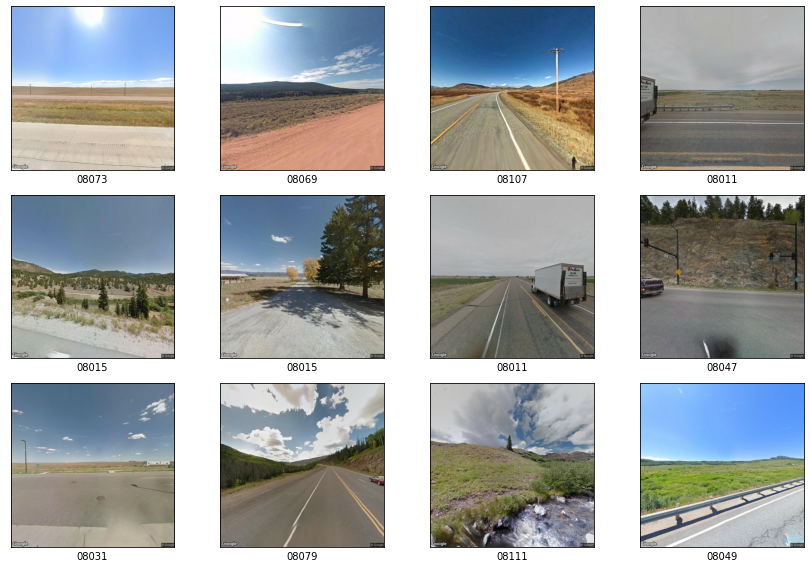

In [ ]:
# Show sample images
pltWidth = 4
pltHeight = 3

f = plt.figure( figsize=(12,8) )

for i in range( pltHeight ):
    for j in range( pltWidth ):
        ax = f.add_subplot( pltHeight, pltWidth, pltWidth*i+j+1 )
        ax.set_xticks( [] )
        ax.set_yticks( [] )
        randomGeoid = random.choice( geoids )
        randomImg = random.choice( geoidsFilenames[randomGeoid] )
        ax.set_xlabel( randomGeoid )
        plt.imshow( image.load_img( randomImg ) )

plt.tight_layout()
plt.show()

In [ ]:
# Make directories to move images into structurers that work with Keras image generators
ttvDir = '/content/drive/My Drive/- 2021 Spring/GBUS 401/AIguessr/Images/Colorado/TTV'

!rm -rf ttvDir

for g in geoids:
    dir_train = ttvDir + '/train/' + g + '/'
    dir_test = ttvDir + '/test/' + g + '/'
    dir_validation = ttvDir + '/validation/' + g + '/'

    os.makedirs( dir_train )
    os.makedirs( dir_test )
    os.makedirs( dir_validation )

print( "Done making directories" )

Done making directories


In [ ]:
# Move files to new directories
TRAIN_AMOUNT = 0.6
TEST_AMOUNT = 0.2
VALID_AMOUNT = 0.2

# Copy files to train, test and validate folders based on GEOID
for g in geoids:
    imgFiles = geoidsFilenames[g]
    random.shuffle( imgFiles )

    LAST_TRAIN_IDX = int( TRAIN_AMOUNT * len( imgFiles ) )
    LAST_TEST_IDX = int( ( TRAIN_AMOUNT + TEST_AMOUNT ) * len( imgFiles ) )
    LAST_VALID_IDX = int( ( TRAIN_AMOUNT + TEST_AMOUNT + VALID_AMOUNT ) * len( imgFiles ) )

    for fn in imgFiles[0:LAST_TRAIN_IDX]:
        shutil.copy( fn, ttvDir + '/train/' + g + '/' + os.path.basename( fn ) )

    for fn in imgFiles[LAST_TRAIN_IDX:LAST_TEST_IDX]:
        shutil.copy( fn, ttvDir + '/test/' + g + '/' + os.path.basename( fn ) )

    for fn in imgFiles[LAST_TEST_IDX:LAST_VALID_IDX]:
        shutil.copy( fn, ttvDir + '/validation/' + g + '/' + os.path.basename( fn ) )